In [2]:
library(rpart)
library(rpart.plot)
library(RColorBrewer)
library(MLmetrics)
library(caret)


Attaching package: 'MLmetrics'


The following object is masked from 'package:base':

    Recall


Loading required package: lattice

Loading required package: ggplot2


Attaching package: 'caret'


The following objects are masked from 'package:MLmetrics':

    MAE, RMSE




In [3]:
setwd('C:/Users/danie/Documents/GitHub/Quantifying-The-World/Case Study 3')
spamPath = "./From 2ds"

In [4]:
dirNames = list.files(path = paste(spamPath, "messages", 
                      sep = .Platform$file.sep))
fullDirNames = paste(spamPath, "messages", dirNames, 
                     sep = .Platform$file.sep)
fileNames = list.files(fullDirNames[1], full.names = TRUE)
msg = readLines(fileNames[1])

In [5]:
indx = c(1:5, 15, 27, 68, 69, 329, 404, 427, 516, 852, 971)
fn = list.files(fullDirNames[1], full.names = TRUE)[indx]
sampleEmail = sapply(fn, readLines)

In [6]:
splitMessage = function(msg) {
    splitPoint = match("", msg)
    header = msg[1:(splitPoint-1)]
    body = msg[ -(1:splitPoint) ]
    return(list(header = header, body = body)) 
}
sampleSplit = lapply(sampleEmail, splitMessage)

In [7]:
header = sampleSplit[[1]]$header
headerList = lapply(sampleSplit, function(msg) msg$header)
CTloc = sapply(headerList, grep, pattern = "Content-Type")

hasAttach = sapply(headerList, function(header) {
  CTloc = grep("Content-Type", header)
  if (length(CTloc) == 0) return(FALSE)
  grepl("multi", tolower(header[CTloc])) 
})

header = sampleSplit[[6]]$header
boundaryIdx = grep("boundary=", header)


header2 = headerList[[9]]
boundaryIdx2 = grep("boundary=", header2)

In [8]:
getBoundary = function(header) {
  boundaryIdx = grep("boundary=", header)
  boundary = gsub('"', "", header[boundaryIdx])
  gsub(".*boundary= *([^;]*);?.*", "\\1", boundary)
}

In [9]:
dropAttach = function(body, boundary){
  
  bString = paste("--", boundary, sep = "")
  bStringLocs = which(bString == body)
  
  if (length(bStringLocs) <= 1) return(body)
  
  eString = paste("--", boundary, "--", sep = "")
  eStringLoc = which(eString == body)
  if (length(eStringLoc) == 0) 
    return(body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1)])
  
  n = length(body)
  if (eStringLoc < n) 
     return( body[ c( (bStringLocs[1] + 1) : (bStringLocs[2] - 1), 
                    ( (eStringLoc + 1) : n )) ] )
  
  return( body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1) ])
}

cleanMsg = tolower(gsub("[[:punct:]0-9[:blank:]]+", " ", msg))

In [10]:
library(tm)
stopWords = stopwords()
cleanSW = tolower(gsub("[[:punct:]0-9[:blank:]]+", " ", stopWords))
SWords = unlist(strsplit(cleanSW, "[[:blank:]]+"))
SWords = SWords[ nchar(SWords) > 1 ]
stopWords = unique(SWords)

Loading required package: NLP


Attaching package: 'NLP'


The following object is masked from 'package:ggplot2':

    annotate




In [11]:
words = unlist(strsplit(cleanMsg, "[[:blank:]]+"))

words = words[ nchar(words) > 1 ]

words = words[ !( words %in% stopWords) ]

cleanText =
function(msg)   {
  tolower(gsub("[[:punct:]0-9[:space:][:blank:]]+", " ", msg))
}

findMsgWords = 
function(msg, stopWords) {
 if(is.null(msg))
  return(character())

 words = unique(unlist(strsplit(cleanText(msg), "[[:blank:]\t]+")))
 
 # drop empty and 1 letter words
 words = words[ nchar(words) > 1]
 words = words[ !( words %in% stopWords) ]
 invisible(words)
}

In [12]:
processAllWords = function(dirName, stopWords) {
    fileNames = list.files(dirName, full.names = TRUE)
    notEmail = grep("cmds$", fileNames)
    if ( length(notEmail) > 0) fileNames = fileNames[ - notEmail ]
    
    messages = lapply(fileNames, readLines, encoding = "latin1")
    
    emailSplit = lapply(messages, splitMessage)
    
    bodyList = lapply(emailSplit, function(msg) msg$body)
    headerList = lapply(emailSplit, function(msg) msg$header)
    rm(emailSplit)
            hasAttach = sapply(headerList, function(header) {
                CTloc = grep("Content-Type", header)
                if (length(CTloc) == 0) return(0)
                multi = grep("multi", tolower(header[CTloc]))
                if (length(multi) == 0) return(0)
                multi
            })
                hasAttach = which(hasAttach > 0)
                boundaries = sapply(headerList[hasAttach], getBoundary)
                bodyList[hasAttach] = mapply(dropAttach, bodyList[hasAttach],
                boundaries, SIMPLIFY = FALSE)
                msgWordsList = lapply(bodyList, findMsgWords, stopWords)
        }

In [13]:
msgWordsList = lapply(fullDirNames, processAllWords, 
                      stopWords = stopWords)

Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/hard_ham/00228.0eaef7857bbbf3ebf5edbbdae2b30493'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/hard_ham/0231.7c6cc716ce3f3bfad7130dd3c8d7b072'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/hard_ham/0250.7c6cc716ce3f3bfad7130dd3c8d7b072'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/spam/00136.faa39d8e816c70f23b4bb8758d8a74f0'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/spam/0143.260a940290dcb61f9327b224a368d4af'"


In [14]:
numMsgs = sapply(msgWordsList, length)
isSpam = rep(c(FALSE, FALSE, FALSE, TRUE, TRUE), numMsgs)
msgWordsList = unlist(msgWordsList, recursive = FALSE)

In [15]:
numEmail = length(isSpam)
numSpam = sum(isSpam)
numHam = numEmail - numSpam

Here is use of sample function

In [16]:
set.seed(418910)
#determine the indices of test spam and ham messages with
testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))
# use these indices to select the word vectors from msgWordsList with
testMsgWords = c((msgWordsList[isSpam])[testSpamIdx],
                 (msgWordsList[!isSpam])[testHamIdx] )
trainMsgWords = c((msgWordsList[isSpam])[ - testSpamIdx], 
                  (msgWordsList[!isSpam])[ - testHamIdx])

testIsSpam = rep(c(TRUE, FALSE), 
                 c(length(testSpamIdx), length(testHamIdx)))
trainIsSpam = rep(c(TRUE, FALSE), 
                 c(numSpam - length(testSpamIdx), 
                   numHam - length(testHamIdx)))

Here are probability estimates

In [17]:
bow = unique(unlist(trainMsgWords))
spamWordCounts = rep(0, length(bow))
names(spamWordCounts) = bow

In [18]:
tmp = lapply(trainMsgWords[trainIsSpam], unique)
tt = table( unlist(tmp) )
spamWordCounts[ names(tt) ] = tt

In [19]:
#For each word in bag of words (bow), we compute the number of
#spam messages in our training set that contain that word.
computeFreqs =
function(wordsList, spam, bow = unique(unlist(wordsList)))
{
   # create a matrix for spam, ham, and log odds
  wordTable = matrix(0.5, nrow = 4, ncol = length(bow), 
                     dimnames = list(c("spam", "ham", 
                                        "presentLogOdds", 
                                        "absentLogOdds"),  bow))

   # For each spam message, add 1 to counts for words in message
  counts.spam = table(unlist(lapply(wordsList[spam], unique)))
  wordTable["spam", names(counts.spam)] = counts.spam + .5
  counts.ham = table(unlist(lapply(wordsList[!spam], unique)))  
  wordTable["ham", names(counts.ham)] = counts.ham + .5  
  numSpam = sum(spam)
  numHam = length(spam) - numSpam

   # Probabilities
  wordTable["spam", ] = wordTable["spam", ]/(numSpam + .5)
  wordTable["ham", ] = wordTable["ham", ]/(numHam + .5)
  
   # log odds
  wordTable["presentLogOdds", ] = 
     log(wordTable["spam",]) - log(wordTable["ham", ])
  wordTable["absentLogOdds", ] = 
     log((1 - wordTable["spam", ])) - log((1 -wordTable["ham", ]))

  invisible(wordTable)
}

In [20]:
trainTable = computeFreqs(trainMsgWords, trainIsSpam)

Now, trainTable can be used to construct the log likelihood ratio for a new message. That is, we select values from the matrix trainTable that correspond to the words that appear in a new message and the words that are absent from the message, and we use these to compute the log likelihood ratio for the message. This value is then used to classify the message as spam or ham.

In [21]:
trainTable

,fight,risk,cancer,http,www,adclick,ws,cfm,pk,slim,...,outdata,allocates,initialize,constants,generality,stringlist,toarray,newinstance,nulls,bloch
spam,0.0109477635,0.09352518,0.016578042,0.81420081,0.5045355,0.0147012825,0.02408508,0.016578042,0.0172036284,0.014075696,...,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04
ham,0.0106807638,0.01434890,0.005070666,0.78811091,0.5811846,0.0003236595,0.01219117,0.014780451,0.0007552055,0.005286439,...,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04
presentLogOdds,0.0246908402,1.87455707,1.184606941,0.03256821,-0.1414302,3.8159979419,0.68088023,0.114773617,3.1258856650,0.979304820,...,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02
absentLogOdds,-0.0002699187,-0.08373918,-0.011633430,-0.13139654,0.1680654,-0.0144867053,-0.01211377,-0.001826225,-0.0165978394,-0.008875237,...,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05


Calculate the log likelihood ratio (LLR) for all of the test messages

In [22]:
computeMsgLLR = function(words, freqTable) 
{
       # Discards words not in training data.
  words = words[!is.na(match(words, colnames(freqTable)))]

       # Find which words are present
  present = colnames(freqTable) %in% words

  sum(freqTable["presentLogOdds", present]) +
    sum(freqTable["absentLogOdds", !present])
}

In [23]:
testLLR = sapply(testMsgWords, computeMsgLLR, trainTable)

Compare the summary statistics of the LLR values for the ham and spam in the test data

In [24]:
tapply(testLLR, testIsSpam, summary)

$`FALSE`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1076.8  -137.2  -108.3  -125.6   -88.6   753.5 

$`TRUE`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 -85.759   -7.506   36.431   84.980  111.270 1457.719 


We need to decide on a cut-oﬀ τ, where we classify a message as spam or ham according to whether or not the LLR exceeds this threshold. We assess the choice of τ using our test data.

In [25]:
typeIErrorRate = 
function(tau, llrVals, spam)
{
  classify = llrVals > tau
  sum(classify & !spam)/sum(!spam)
}

typeIErrorRates = 
function(llrVals, isSpam) 
{
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]

  idx = which(!isSpam)
  N = length(idx)
  list(error = (N:1)/N, values = llrVals[idx])
}

In [26]:
typeIErrorRate(33, testLLR,testIsSpam)

[1] 0.001294778

In [27]:
typeIIErrorRates = function(llrVals, isSpam) {
    
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]
    
    
  idx = which(isSpam)
  N = length(idx)
  list(error = (1:(N))/N, values = llrVals[idx])
  }  

xI = typeIErrorRates(testLLR, testIsSpam)
xII = typeIIErrorRates(testLLR, testIsSpam)
tau01 = round(min(xI$values[xI$error <= 0.01]))
t2 = max(xII$error[ xII$values < tau01 ])

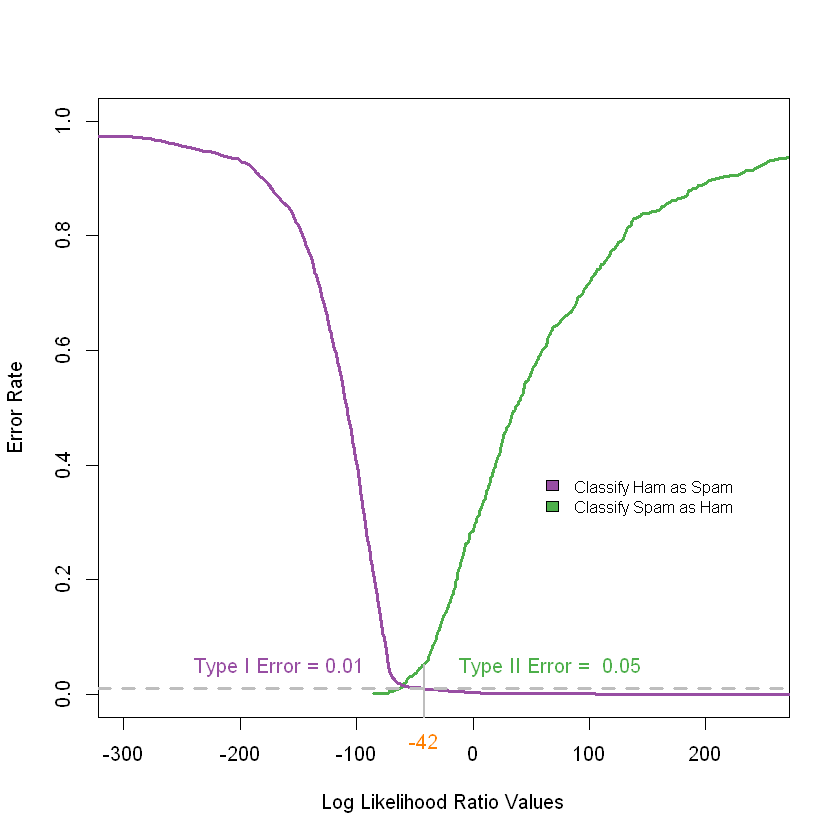

In [28]:
library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(xII$error ~ xII$values,  type = "l", col = cols[1], lwd = 3,
     xlim = c(-300, 250), ylim = c(0, 1),
     xlab = "Log Likelihood Ratio Values", ylab="Error Rate")
points(xI$error ~ xI$values, type = "l", col = cols[2], lwd = 3)
legend(x = 50, y = 0.4, fill = c(cols[2], cols[1]),
       legend = c("Classify Ham as Spam", 
                  "Classify Spam as Ham"), cex = 0.8,
       bty = "n")
abline(h=0.01, col ="grey", lwd = 3, lty = 2)
text(-250, 0.05, pos = 4, "Type I Error = 0.01", col = cols[2])

mtext(tau01, side = 1, line = 0.5, at = tau01, col = cols[3])
segments(x0 = tau01, y0 = -.50, x1 = tau01, y1 = t2, 
         lwd = 2, col = "grey")
text(tau01 + 20, 0.05, pos = 4,
     paste("Type II Error = ", round(t2, digits = 2)), 
     col = cols[1])

In [29]:
readEmail = function(dirName) {
    fileNames = list.files(dirName, full.names = TRUE)
    notEmail = grep("cmds$", fileNames)
    if ( length(notEmail) > 0) fileNames = fileNames[ - notEmail ]
    lapply(fileNames, readLines, encoding = "latin1")
}

In [30]:
processHeader = function(header)
{
       # modify the first line to create a key:value pair
  header[1] = sub("^From", "Top-From:", header[1])
  
  headerMat = read.dcf(textConnection(header), all = TRUE)
  headerVec = unlist(headerMat)
  
  dupKeys = sapply(headerMat, function(x) length(unlist(x)))
  names(headerVec) = rep(colnames(headerMat), dupKeys)
  
  return(headerVec)
}

In [31]:
processAttach = function(body, contentType){

  n = length(body)
  boundary = getBoundary(contentType)
 
  bString = paste("--", boundary, sep = "")
  bStringLocs = which(bString == body)
  eString = paste("--", boundary, "--", sep = "")
  eStringLoc = which(eString == body)
  
  if (length(eStringLoc) == 0) eStringLoc = n
  if (length(bStringLocs) <= 1) {
    attachLocs = NULL
    msgLastLine = n
    if (length(bStringLocs) == 0) bStringLocs = 0
  } else {
    attachLocs = c(bStringLocs[ -1 ],  eStringLoc)
    msgLastLine = bStringLocs[2] - 1
  }
  
  msg = body[ (bStringLocs[1] + 1) : msgLastLine] 
  if ( eStringLoc < n )
    msg = c(msg, body[ (eStringLoc + 1) : n ])
  
  if ( !is.null(attachLocs) ) {
    attachLens = diff(attachLocs, lag = 1) 
    attachTypes = mapply(function(begL, endL) {
      CTloc = grep("^[Cc]ontent-[Tt]ype", body[ (begL + 1) : (endL - 1)])
      if ( length(CTloc) == 0 ) {
        MIMEType = NA
      } else {
        CTval = body[ begL + CTloc[1] ]
        CTval = gsub('"', "", CTval )
        MIMEType = sub(" *[Cc]ontent-[Tt]ype: *([^;]*);?.*", "\\1", CTval)   
      }
      return(MIMEType)
    }, attachLocs[-length(attachLocs)], attachLocs[-1])
  }
  
  if (is.null(attachLocs)) return(list(body = msg, attachDF = NULL) )
  return(list(body = msg, 
             attachDF = data.frame(aLen = attachLens, 
                                     aType = unlist(attachTypes),
                                     stringsAsFactors = FALSE)))                                
}                       

In [32]:
processAllEmail = function(dirName, isSpam = FALSE)
{
       # read all files in the directory
  messages = readEmail(dirName)
  fileNames = names(messages)
  n = length(messages)
  
       # split header from body
  eSplit = lapply(messages, splitMessage)
  rm(messages)

       # process header as named character vector
  headerList = lapply(eSplit, function(msg) 
                                 processHeader(msg$header))
  
       # extract content-type key
  contentTypes = sapply(headerList, function(header) 
                                       header["Content-Type"])
  
       # extract the body
  bodyList = lapply(eSplit, function(msg) msg$body)
  rm(eSplit)

       # which email have attachments
  hasAttach = grep("^ *multi", tolower(contentTypes))

       # get summary stats for attachments and the shorter body
  attList = mapply(processAttach, bodyList[hasAttach], 
                   contentTypes[hasAttach], SIMPLIFY = FALSE)
  
  bodyList[hasAttach] = lapply(attList, function(attEl) 
                                           attEl$body)
 
  attachInfo = vector("list", length = n )
  attachInfo[ hasAttach ] = lapply(attList, 
                                  function(attEl) attEl$attachDF)
 
       # prepare return structure
  emailList = mapply(function(header, body, attach, isSpam) {
                       list(isSpam = isSpam, header = header, 
                            body = body, attach = attach)
                     },
                     headerList, bodyList, attachInfo, 
                     rep(isSpam, n), SIMPLIFY = FALSE )
  names(emailList) = fileNames
  
  invisible(emailList)
}

In [33]:
emailStruct = mapply(processAllEmail, fullDirNames,
                     isSpam = rep( c(FALSE, TRUE), 3:2))
emailStruct = unlist(emailStruct, recursive = FALSE)

Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/hard_ham/00228.0eaef7857bbbf3ebf5edbbdae2b30493'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/hard_ham/0231.7c6cc716ce3f3bfad7130dd3c8d7b072'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/hard_ham/0250.7c6cc716ce3f3bfad7130dd3c8d7b072'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/spam/00136.faa39d8e816c70f23b4bb8758d8a74f0'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/spam/0143.260a940290dcb61f9327b224a368d4af'"


In [34]:
sampleStruct = emailStruct[ indx ]

In [35]:
save(emailStruct, file="emailXX.rda")

In [36]:
funcList = list(
  isSpam =
    expression(msg$isSpam)
  ,
  isRe =
    function(msg) {
      # Can have a Fwd: Re:  ... but we are not looking for this here.
      # We may want to look at In-Reply-To field.
      "Subject" %in% names(msg$header) && 
        length(grep("^[ \t]*Re:", msg$header[["Subject"]])) > 0
    }
  ,
  numLines =
    function(msg) length(msg$body)
  ,
  bodyCharCt =
    function(msg)
      sum(nchar(msg$body))
  ,
  underscore =
    function(msg) {
      if(!"Reply-To" %in% names(msg$header))
        return(FALSE)
      
      txt <- msg$header[["Reply-To"]]
      length(grep("_", txt)) > 0  && 
        length(grep("[0-9A-Za-z]+", txt)) > 0
    }
  ,
  subExcCt = 
    function(msg) {
      x = msg$header["Subject"]
      if(length(x) == 0 || sum(nchar(x)) == 0 || is.na(x))
        return(NA)
      
      sum(nchar(gsub("[^!]","", x)))
    }
  ,
  subQuesCt =
    function(msg) {
      x = msg$header["Subject"]
      if(length(x) == 0 || sum(nchar(x)) == 0 || is.na(x))
        return(NA)
      
      sum(nchar(gsub("[^?]","", x)))
    }
  ,
  numAtt = 
    function(msg) {
      if (is.null(msg$attach)) return(0)
      else nrow(msg$attach)
    }
   
  ,
  priority =
    function(msg) {
      ans <- FALSE
      # Look for names X-Priority, Priority, X-Msmail-Priority
      # Look for high any where in the value
      ind = grep("priority", tolower(names(msg$header)))
      if (length(ind) > 0)  {
        ans <- length(grep("high", tolower(msg$header[ind]))) >0
      }
      ans
    }
  ,
  numRec =
    function(msg) {
      # unique or not.
      els = getMessageRecipients(msg$header)
      
      if(length(els) == 0)
        return(NA)
      
      # Split each line by ","  and in each of these elements, look for
      # the @ sign. This handles
      tmp = sapply(strsplit(els, ","), function(x) grep("@", x))
      sum(sapply(tmp, length))
    }
  ,
  perCaps =
    function(msg)
    {
      body = paste(msg$body, collapse = "")
      
      # Return NA if the body of the message is "empty"
      if(length(body) == 0 || nchar(body) == 0) return(NA)
      
      # Eliminate non-alpha characters and empty lines 
      body = gsub("[^[:alpha:]]", "", body)
      els = unlist(strsplit(body, ""))
      ctCap = sum(els %in% LETTERS)
      100 * ctCap / length(els)
    }
  ,
  isInReplyTo =
    function(msg)
    {
      "In-Reply-To" %in% names(msg$header)
    }
  ,
  sortedRec =
    function(msg)
    {
      ids = getMessageRecipients(msg$header)
      all(sort(ids) == ids)
    }
  ,
  subPunc =
    function(msg)
    {
      if("Subject" %in% names(msg$header)) {
        el = gsub("['/.:@-]", "", msg$header["Subject"])
        length(grep("[A-Za-z][[:punct:]]+[A-Za-z]", el)) > 0
      }
      else
        FALSE
    },
  hour =
    function(msg)
    {
      date = msg$header["Date"]
      if ( is.null(date) ) return(NA)
      # Need to handle that there may be only one digit in the hour
      locate = regexpr("[0-2]?[0-9]:[0-5][0-9]:[0-5][0-9]", date)
      
      if (locate < 0)
        locate = regexpr("[0-2]?[0-9]:[0-5][0-9]", date)
      if (locate < 0) return(NA)
      
      hour = substring(date, locate, locate+1)
      hour = as.numeric(gsub(":", "", hour))
      
      locate = regexpr("PM", date)
      if (locate > 0) hour = hour + 12
      
      locate = regexpr("[+-][0-2][0-9]00", date)
      if (locate < 0) offset = 0
      else offset = as.numeric(substring(date, locate, locate + 2))
      (hour - offset) %% 24
    }
  ,
  multipartText =
    function(msg)
    {
      if (is.null(msg$attach)) return(FALSE)
      numAtt = nrow(msg$attach)
      
      types = 
        length(grep("(html|plain|text)", msg$attach$aType)) > (numAtt/2)
    }
  ,
  hasImages =
    function(msg)
    {
      if (is.null(msg$attach)) return(FALSE)
      
      length(grep("^ *image", tolower(msg$attach$aType))) > 0
    }
  ,
  isPGPsigned =
    function(msg)
    {
      if (is.null(msg$attach)) return(FALSE)
      
      length(grep("pgp", tolower(msg$attach$aType))) > 0
    },
  perHTML =
    function(msg)
    {
      if(! ("Content-Type" %in% names(msg$header))) return(0)
      
      el = tolower(msg$header["Content-Type"]) 
      if (length(grep("html", el)) == 0) return(0)
      
      els = gsub("[[:space:]]", "", msg$body)
      totchar = sum(nchar(els))
      totplain = sum(nchar(gsub("<[^<]+>", "", els )))
      100 * (totchar - totplain)/totchar
    },
  subSpamWords =
    function(msg)
    {
      if("Subject" %in% names(msg$header))
        length(grep(paste(SpamCheckWords, collapse = "|"), 
                    tolower(msg$header["Subject"]))) > 0
      else
        NA
    }
  ,
  subBlanks =
    function(msg)
    {
      if("Subject" %in% names(msg$header)) {
        x = msg$header["Subject"]
        # should we count blank subject line as 0 or 1 or NA?
        if (nchar(x) == 1) return(0)
        else 100 *(1 - (nchar(gsub("[[:blank:]]", "", x))/nchar(x)))
      } else NA
    }
  ,
  noHost =
    function(msg)
    {
      # Or use partial matching.
      idx = pmatch("Message-", names(msg$header))
      
      if(is.na(idx)) return(NA)
      
      tmp = msg$header[idx]
      return(length(grep(".*@[^[:space:]]+", tmp)) ==  0)
    }
  ,
  numEnd =
    function(msg)
    {
      # If we just do a grep("[0-9]@",  )
      # we get matches on messages that have a From something like
      # " \"marty66@aol.com\" <synjan@ecis.com>"
      # and the marty66 is the "user's name" not the login
      # So we can be more precise if we want.
      x = names(msg$header)
      if ( !( "From" %in% x) ) return(NA)
      login = gsub("^.*<", "", msg$header["From"])
      if ( is.null(login) ) 
        login = gsub("^.*<", "", msg$header["X-From"])
      if ( is.null(login) ) return(NA)
      login = strsplit(login, "@")[[1]][1]
      length(grep("[0-9]+$", login)) > 0
    },
  isYelling =
    function(msg)
    {
      if ( "Subject" %in% names(msg$header) ) {
        el = gsub("[^[:alpha:]]", "", msg$header["Subject"])
        if (nchar(el) > 0) nchar(gsub("[A-Z]", "", el)) < 1
        else FALSE
      }
      else
        NA
    },
  forwards =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0 || sum(nchar(x)) == 0)
        return(NA)
      
      ans = length(grep("^[[:space:]]*>", x))
      100 * ans / length(x)
    },
  isOrigMsg =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0) return(NA)
      
      length(grep("^[^[:alpha:]]*original[^[:alpha:]]+message[^[:alpha:]]*$", 
                  tolower(x) ) ) > 0
    },
  isDear =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0) return(NA)
      
      length(grep("^[[:blank:]]*dear +(sir|madam)\\>", 
                  tolower(x))) > 0
    },
  isWrote =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0) return(NA)
      
      length(grep("(wrote|schrieb|ecrit|escribe):", tolower(x) )) > 0
    },
  avgWordLen =
    function(msg)
    {
      txt = paste(msg$body, collapse = " ")
      if(length(txt) == 0 || sum(nchar(txt)) == 0) return(0)
      
      txt = gsub("[^[:alpha:]]", " ", txt)
      words = unlist(strsplit(txt, "[[:blank:]]+"))
      wordLens = nchar(words)
      mean(wordLens[ wordLens > 0 ])
    }
  ,
  numDlr =
    function(msg)
    {
      x = paste(msg$body, collapse = "")
      if(length(x) == 0 || sum(nchar(x)) == 0)
        return(NA)
      
      nchar(gsub("[^$]","", x))
    }
)


SpamCheckWords =
  c("viagra", "pounds", "free", "weight", "guarantee", "million", 
    "dollars", "credit", "risk", "prescription", "generic", "drug",
    "financial", "save", "dollar", "erotic", "million", "barrister",
    "beneficiary", "easy", 
    "money back", "money", "credit card")


getMessageRecipients =
  function(header)
  {
    c(if("To" %in% names(header))  header[["To"]] else character(0),
      if("Cc" %in% names(header))  header[["Cc"]] else character(0),
      if("Bcc" %in% names(header)) header[["Bcc"]] else character(0)
    )
  }

In [37]:
createDerivedDF =
function(email = emailStruct, operations = funcList, 
         verbose = FALSE)
{
  els = lapply(names(operations),
               function(id) {
                 if(verbose) print(id)
                 e = operations[[id]]
                 v = if(is.function(e)) 
                        sapply(email, e)
                      else 
                        sapply(email, function(msg) eval(e))
                 v
         })

   df = as.data.frame(els)
   names(df) = names(operations)
   invisible(df)
}

In [38]:
# emailDF = createDerivedDF(emailStruct)
#save(emailDF, file = "spamAssassinDerivedDF.rda")
# dim(emailDF)
load("spamAssassinDerivedDF.rda")

In [39]:
library(rpart)
setupRpart = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.factor(x)
                      levels(x) = c("F", "T")
                      x
                   })
  cbind(facVars, data[ , - logicalVars])
}

In [40]:
emailDFrp = setupRpart(emailDF)

In [41]:
set.seed(418910)
testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))

testDF = 
  rbind( emailDFrp[ emailDFrp$isSpam == "T", ][testSpamIdx, ],
         emailDFrp[emailDFrp$isSpam == "F", ][testHamIdx, ] )
trainDF =
  rbind( emailDFrp[emailDFrp$isSpam == "T", ][-testSpamIdx, ], 
         emailDFrp[emailDFrp$isSpam == "F", ][-testHamIdx, ])

In [42]:
rpartFit = rpart(isSpam ~ ., data = trainDF, method = "class")

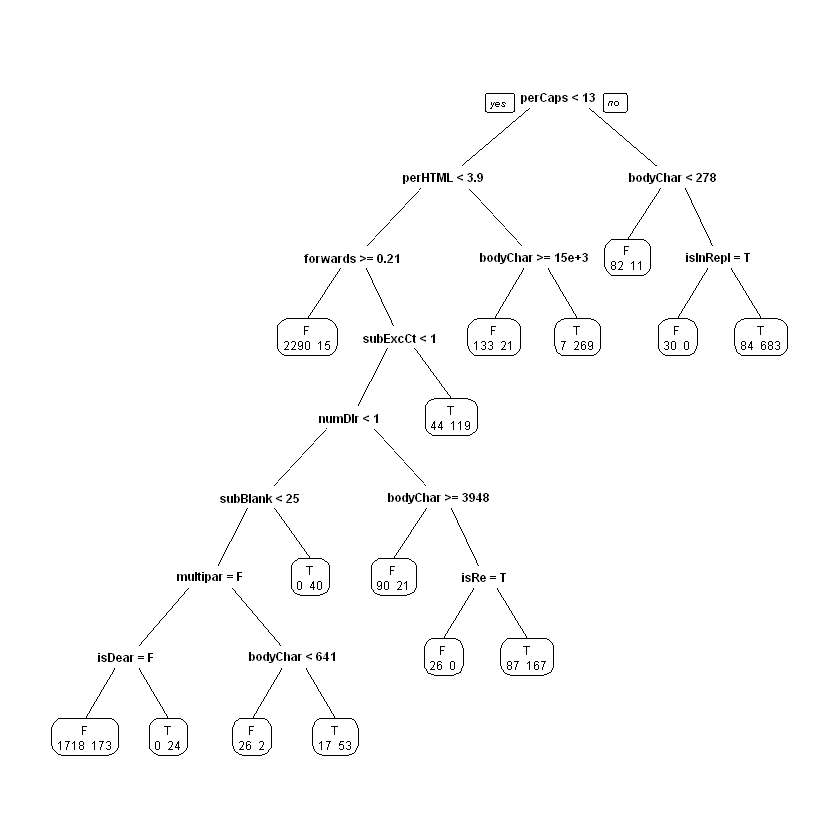

In [43]:
library(rpart.plot)
prp(rpartFit, extra = 1)

In [44]:
predictions = predict(rpartFit, 
       newdata = testDF[, names(testDF) != "isSpam"],
       type = "class")

In [45]:
predsForHam = predictions[ testDF$isSpam == "F" ]
summary(predsForHam)

sum(predsForHam == "T") / length(predsForHam)

predsForSpam = predictions[ testDF$isSpam == "T" ]
sum(predsForSpam == "F") / length(predsForSpam)

F    T 
2167  150

[1] 0.06473889

[1] 0.1864831

In [46]:
complexityVals = c(seq(0.00001, 0.0001, length=19),
                   seq(0.0001, 0.001, length=19), 
                   seq(0.001, 0.005, length=9),
                   seq(0.005, 0.01, length=9))

fits = lapply(complexityVals, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(cp=x) )
           
         predict(rpartObj, 
                 newdata = testDF[ , names(testDF) != "isSpam"],
                 type = "class")
        })

spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
                     })

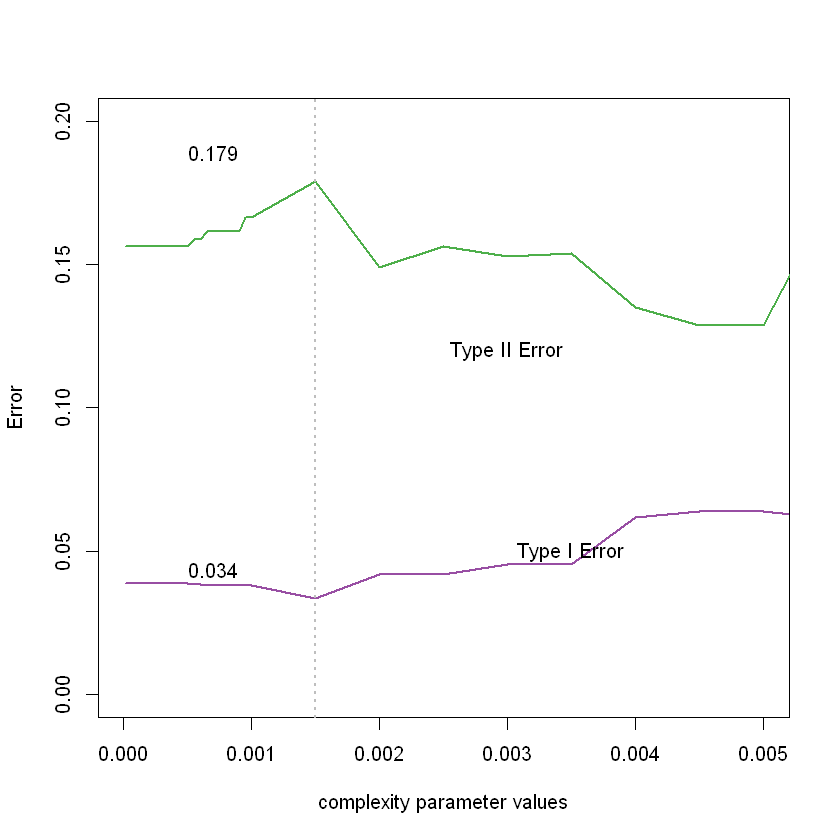

In [47]:
library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(errs[1,] ~ complexityVals, type="l", col=cols[2], 
     lwd = 2, ylim = c(0,0.2), xlim = c(0,0.005), 
     ylab="Error", xlab="complexity parameter values")
points(errs[2,] ~ complexityVals, type="l", col=cols[1], lwd = 2)

text(x =c(0.003, 0.0035), y = c(0.12, 0.05), 
     labels=c("Type II Error", "Type I Error"))

minI = which(errs[1,] == min(errs[1,]))[1]
abline(v = complexityVals[minI], col ="grey", lty =3, lwd=2)

text(0.0007, errs[1, minI]+0.01, 
     formatC(errs[1, minI], digits = 2))
text(0.0007, errs[2, minI]+0.01, 
     formatC(errs[2, minI], digits = 3))